In [1]:
    #   !pip install albumentations==0.4.5

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensor
from data.transformations import Transformations
from data.downloader import Downloader
from data.dataloader import Dataloader
from data.utils import cal_mean, cal_std, image_size
from tqdm import tqdm
from model.regularizer import l1_regularization
from model.train import train 
from model.test import val
from model.network import *
import matplotlib.pyplot as plt
import plotter
import cv2

from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
downloader = Downloader('./data', 'CIFAR10')
sample = downloader.download_sample(train = True)

Files already downloaded and verified


In [4]:
batch_size = 64
num_workers = 4
total_epochs = 50
min_lr = 1e-6
end_lr = 1
momentum = 0.9
num_iter = 500

args = {
    'mean': (0.5, 0.5, 0.5),
    'std': (0.5, 0.5, 0.5),
    'train': False
}
args['train'] = True
args['horizontal_flip_prob'] = 0.2
args['vertical_flip_prob'] = 0.0
args['gaussian_blur_prob'] = 0.0
args['rotate_degree'] = 20
args['cutout'] = 0.3
args['cutout_height'] = 16
args['cutout_width'] = 16
args['mean'] = cal_mean(sample)  # calculate mean
args['std'] = cal_std(sample)   # calculate standard deviation
# print(args['mean'])
classes = sample.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
transformations = Transformations(**args)
trainset = downloader.download(transformations)
args['train'] = False
transformations = Transformations(**args)
testset = downloader.download(transformations, train = False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:

trainloader = Dataloader.getloader(trainset, batch_size, num_workers)
testloader = Dataloader.getloader(testset, batch_size, num_workers, train = False)

In [7]:
cuda = torch.cuda.is_available()
print('GPU Available?', cuda)
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

GPU Available? True


In [8]:
from torchsummary import summary
model = ResNet18().to(device)  # Create model
# size = image_size(sample)
# print(summary(model, input_size = size))

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=momentum)

In [10]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=end_lr, num_iter=num_iter, step_mode='exp')


Learning rate search finished. See the graph with {finder_name}.plot()


Loss: 1.7474181062069307
Initial LR suggestion: Minimum Loss
Best Initial LR: 4.16E-03


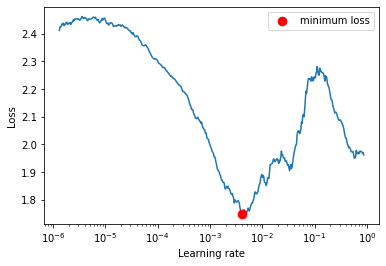

In [11]:

# Print loss
print('Loss:', lr_finder.best_loss)

# return best initial lr
# Plot learning rate vs loss
_, best_initial_lr = lr_finder.plot()
# print(best_initial_lr)
# Reset graph
lr_finder.reset()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_initial_lr, momentum=momentum)
scheduler = ReduceLROnPlateau(optimizer)

In [13]:

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(1, total_epochs + 1):
    print(f'Epoch {epoch}:')
    train_loss, train_accuracy = train(model, trainloader, device, optimizer, criterion)
    val_loss, val_accuracy = val(model, testloader, device, criterion)
    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    val_losses.append(val_loss), val_accuracies.append(val_accuracy)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0157, Accuracy: 6456/10000 (64.56%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0119, Accuracy: 7371/10000 (73.71%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0096, Accuracy: 7876/10000 (78.76%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0094, Accuracy: 7998/10000 (79.98%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0105, Accuracy: 7828/10000 (78.28%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 8273/10000 (82.73%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8407/10000 (84.07%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 8368/10000 (83.68%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8375/10000 (83.75%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0073, Accuracy: 8468/10000 (84.68%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8487/10000 (84.87%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0083, Accuracy: 8369/10000 (83.69%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8674/10000 (86.74%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8573/10000 (85.73%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8662/10000 (86.62%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0064, Accuracy: 8765/10000 (87.65%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8701/10000 (87.01%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8808/10000 (88.08%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 8760/10000 (87.60%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8790/10000 (87.90%)

Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8796/10000 (87.96%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8726/10000 (87.26%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8807/10000 (88.07%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8872/10000 (88.72%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8884/10000 (88.84%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8884/10000 (88.84%)

Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8902/10000 (89.02%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 8828/10000 (88.28%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0068, Accuracy: 8815/10000 (88.15%)

Epoch 30:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8957/10000 (89.57%)

Epoch 31:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0064, Accuracy: 8915/10000 (89.15%)

Epoch 32:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8873/10000 (88.73%)

Epoch 33:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8948/10000 (89.48%)

Epoch 34:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0064, Accuracy: 8928/10000 (89.28%)

Epoch 35:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8950/10000 (89.50%)

Epoch 36:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8854/10000 (88.54%)

Epoch 37:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8971/10000 (89.71%)

Epoch 38:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0065, Accuracy: 8907/10000 (89.07%)

Epoch 39:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8961/10000 (89.61%)

Epoch 40:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0060, Accuracy: 8976/10000 (89.76%)

Epoch 41:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8993/10000 (89.93%)

Epoch 42:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8992/10000 (89.92%)

Epoch 43:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8939/10000 (89.39%)

Epoch 44:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8960/10000 (89.60%)

Epoch 45:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0076, Accuracy: 8880/10000 (88.80%)

Epoch 46:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8974/10000 (89.74%)

Epoch 47:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0070, Accuracy: 8901/10000 (89.01%)

Epoch 48:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8945/10000 (89.45%)

Epoch 49:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8987/10000 (89.87%)

Epoch 50:


Loss=0.06 Batch_ID=781 Accuracy=98.07: 100%|██████████| 782/782 [01:07<00:00, 11.58it/s]



Validation set: Average loss: 0.0061, Accuracy: 9014/10000 (90.14%)



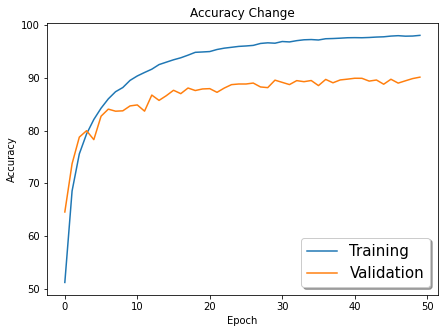

In [14]:
plotter.plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

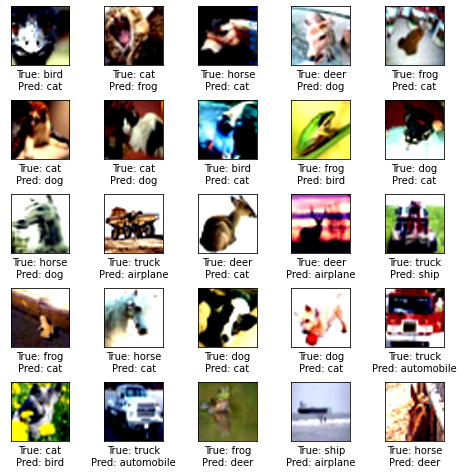

In [15]:
incorrect_images, incorrect_labels, true_labels = plotter.get_incorrect_predictions(testloader, model, device, 25)
plotter.plot_images(5, 5, incorrect_images, classes, true_labels, 'incorrect', incorrect_labels)

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


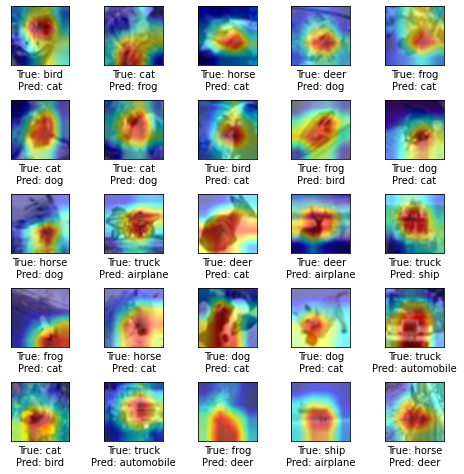

In [16]:
import gradcam
# correct_samples = np.array(correct_samples)
grad_cam = gradcam.GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, args['mean'], args['std']
)

# images = [x['image'] for x in random.sample(correct_samples, 4)]
cam_images = grad_cam(incorrect_images, './grad_cam', 'result', 'layer4')
plotter.plot_cam_view(5, 5, cam_images, classes, true_labels, 'incorrect_cam', incorrect_labels)
# allimages = []
# for item in grad_cam.views:
#     allimages.append(item['result']['layer1'])
# plot_imgs(5, 5, allimages, classes, true_labels, incorrect_labels)